In [1]:
# @title
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
import re

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, mean_squared_error, r2_score
from sklearn.linear_model import RidgeCV, LassoCV

In [2]:
passing = pd.read_csv("Total_Passing.csv")
penalties = pd.read_csv("Total_Penalties.csv")
receiving = pd.read_csv("Total_Receiving.csv")
rushing = pd.read_csv("Total_Rushing.csv")

'''Model 1: total rushing yards from
offensive holding,
false start,
unnecessary roughness,
illegal block above the waist,
illegal use of hands,
rushing attempts,
fumbles,
and 20+ yard rushing plays
'''

'''Model 2: total passing yards from
interceptions thrown,
sack yards lost,
QBR,
completions,
intentional grounding,
offensive holding,
and OPI
'''

#Replacing Oakland with Las Vegas
penalties['Team'] = penalties['Team'].replace('Oakland', 'Las Vegas')

#Replacing full team names with abbreviations
team_name_map = {
    "Arizona": "ARI", "Atlanta": "ATL", "Baltimore": "BAL", "Buffalo": "BUF", "Carolina": "CAR",
    "Chicago": "CHI", "Cincinnati": "CIN", "Cleveland": "CLE", "Dallas": "DAL", "Denver": "DEN",
    "Detroit": "DET", "Green Bay": "GB", "Houston": "HOU", "Indianapolis": "IND", "Jacksonville": "JAX",
    "Kansas City": "KC", "Las Vegas": "LV", "LA Chargers": "LAC", "LA Rams": "LAR", "Miami": "MIA",
    "Minnesota": "MIN", "New England": "NE", "New Orleans": "NO", "N.Y. Giants": "NYG", "N.Y. Jets": "NYJ",
    "Philadelphia": "PHI", "Pittsburgh": "PIT", "San Francisco": "SF", "Seattle": "SEA",
    "Tampa Bay": "TB", "Tennessee": "TEN", "Washington": "WAS"
}
penalties["Team"] = penalties["Team"].map(team_name_map)

oak_map = {
    "ARI": "ARI", "ATL": "ATL", "BAL": "BAL", "BUF": "BUF", "CAR": "CAR",
    "CHI": "CHI", "CIN": "CIN", "CLE": "CLE", "DAL": "DAL", "DEN": "DEN",
    "DET": "DET", "GB": "GB", "HOU": "HOU", "IND": "IND", "JAX": "JAX",
    "KC": "KC", "LV": "LV", "LAC": "LAC", "LAR": "LAR", "MIA": "MIA",
    "MIN": "MIN", "NE": "NE", "NO": "NO", "NYG": "NYG", "NYJ": "NYJ",
    "PHI": "PHI", "PIT": "PIT", "SF": "SF", "SEA": "SEA",
    "TB": "TB", "TEN": "TEN", "WSH": "WAS", "OAK": "LV"
}
rushing['Team'] = rushing['Team'].map(oak_map)
passing['Team'] = passing['Team'].map(oak_map)
receiving['Team'] = receiving['Team'].map(oak_map)

#Extracting all penalties that are used as features from the Penalty Types column
penalties["Offensive Holding"] = 0
offensive_holding = penalties["Penalty Types"].str.extract(r"Offensive Holding \((\d+)\)")
penalties["Offensive Holding"] = offensive_holding[0].fillna(0).astype(int)

penalties["False Start"] = 0
false_start = penalties["Penalty Types"].str.extract(r"False Start \((\d+)\)")
penalties["False Start"] = false_start[0].fillna(0).astype(int)

penalties["Unnecessary Roughness"] = 0
unecessary_roughness = penalties["Penalty Types"].str.extract(r"Unnecessary Roughness \((\d+)\)")
penalties["Unnecessary Roughness"] = unecessary_roughness[0].fillna(0).astype(int)

penalties["Illegal Block Above the Waist"] = 0
illegal_block = penalties["Penalty Types"].str.extract(r"Illegal Block Above the Waist \((\d+)\)")
penalties["Illegal Block Above the Waist"] = illegal_block[0].fillna(0).astype(int)

penalties["Illegal Use of Hands"] = 0
illegal_use_hands = penalties["Penalty Types"].str.extract(r"Illegal Use of Hands \((\d+)\)")
penalties["Illegal Use of Hands"] = illegal_use_hands[0].fillna(0).astype(int)

penalties["Intentional Grounding"] = 0
intentional_grounding = penalties["Penalty Types"].str.extract(r"Intentional Grounding \((\d+)\)")
penalties["Intentional Grounding"] = intentional_grounding[0].fillna(0).astype(int)


penalties["Offensive Pass Interference"] = 0
opi = penalties["Penalty Types"].str.extract(r"Offensive Pass Interference \((\d+)\)")
penalties["Offensive Pass Interference"] = opi[0].fillna(0).astype(int)

#Selecting relevant penalties columns and summing the penalty counts
penalties = penalties[["Team", "Year", "Offensive Holding", "False Start", "Unnecessary Roughness", "Illegal Block Above the Waist", "Illegal Use of Hands", "Intentional Grounding", "Offensive Pass Interference"]]
penalties = penalties.groupby(['Team', 'Year']).sum().reset_index()

#Typecasting rushing and passing yards
rushing['Rushing Yards'] = rushing['Rushing Yards'].str.replace(',', '').astype(int)
rushing = rushing[["Team", "Rushing Attempts", "Rushing Yards", "20+ Yard Rushes", "Rushing Fumbles", "Year"]]
rushing = rushing.groupby(['Team', 'Year']).sum().reset_index()

passing['Passing Yards'] = passing['Passing Yards'].str.replace(',', '').astype(int)
passing = passing[["Team", "Completions", "Passing Yards", "Interceptions", "Total Sacks", "Sack Yards Lost", "Adjusted QBR", "Year"]]
passing = passing.groupby(['Team', 'Year']).sum().reset_index()

#Creating datasets for modeling
big_dataset = pd.merge(pd.merge(penalties, passing, on=['Team', 'Year']), rushing, on=['Team', 'Year'])

model1 = big_dataset[["Rushing Yards", "Offensive Holding", "False Start", "Unnecessary Roughness", "Illegal Block Above the Waist", "Illegal Use of Hands", "Rushing Attempts", "Rushing Fumbles", "20+ Yard Rushes"]]

model2 = big_dataset[["Passing Yards", "Interceptions", "Sack Yards Lost", "Adjusted QBR", "Completions", "Intentional Grounding", "Offensive Holding", "Offensive Pass Interference"]]

Sum of All Rows Each Variable for Rushing Yards Question


,Rushing Yards,Offensive Holding,False Start,Unnecessary Roughness,Illegal Block Above the Waist,Illegal Use of Hands,Rushing Attempts,Rushing Fumbles,20+ Yard Rushes
Sum,357715,2589,2151,465,180,309,81886,1261,2002


Sum of All Rows Each Variable for Passing Yards Question


,Passing Yards,Interceptions,Sack Yards Lost,Adjusted QBR,Completions,Intentional Grounding,Offensive Holding,Offensive Pass Interference
Sum,757597.0,2418.0,49984.0,26111.9,68664.0,71.0,2589.0,196.0


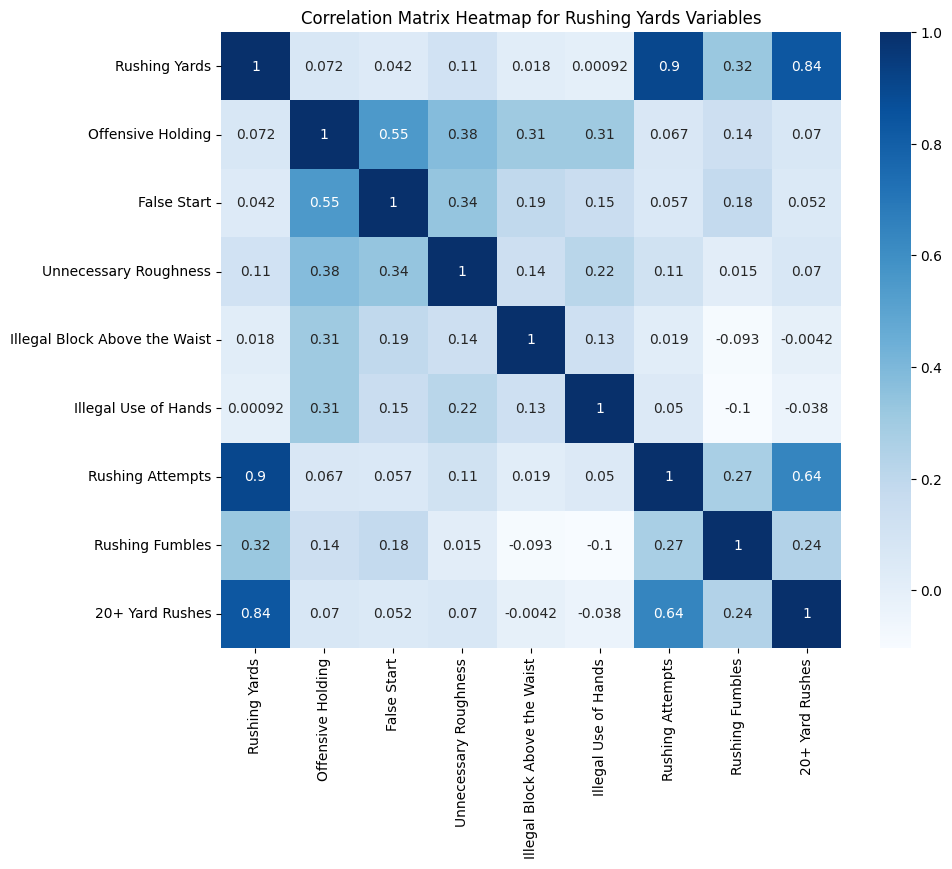

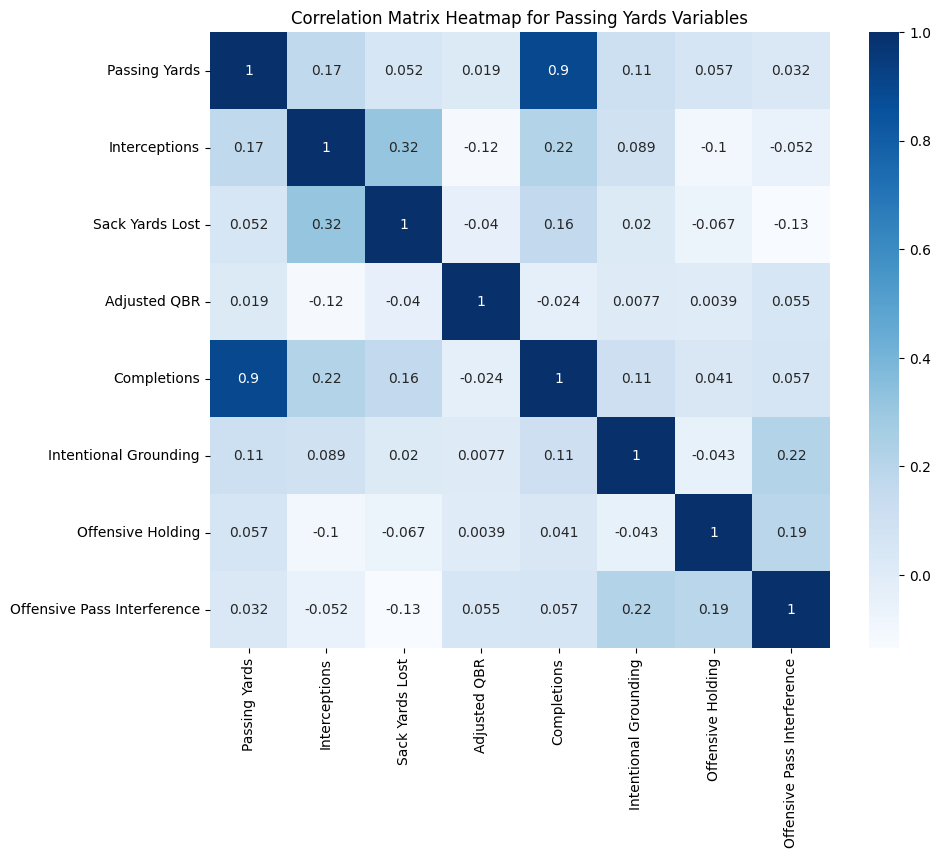

In [3]:
#Table of Penalty counts for question 1
model1_sums = model1.sum()
model1_sums_df = pd.DataFrame(model1_sums).transpose()
model1_sums_df.index = ['Sum']
print('Sum of All Rows Each Variable for Rushing Yards Question')
display(model1_sums_df)

#Table of Penalty counts for question 2
model2_sums = model2.sum()
model2_sums_df = pd.DataFrame(model2_sums).transpose()
model2_sums_df.index = ['Sum']
print('Sum of All Rows Each Variable for Passing Yards Question')
display(model2_sums_df)

#Correlation heatmap for question 1
model1_matrix = model1.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(model1_matrix, annot=True, cmap='Blues')
plt.title('Correlation Matrix Heatmap for Rushing Yards Variables')
plt.show();

#Correlation heatmap for question 2
model2_matrix = model2.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(model2_matrix, annot=True, cmap='Blues')
plt.title('Correlation Matrix Heatmap for Passing Yards Variables')
plt.show();

Baseline R² Score: -0.4178
Baseline RMSE: 459.6946


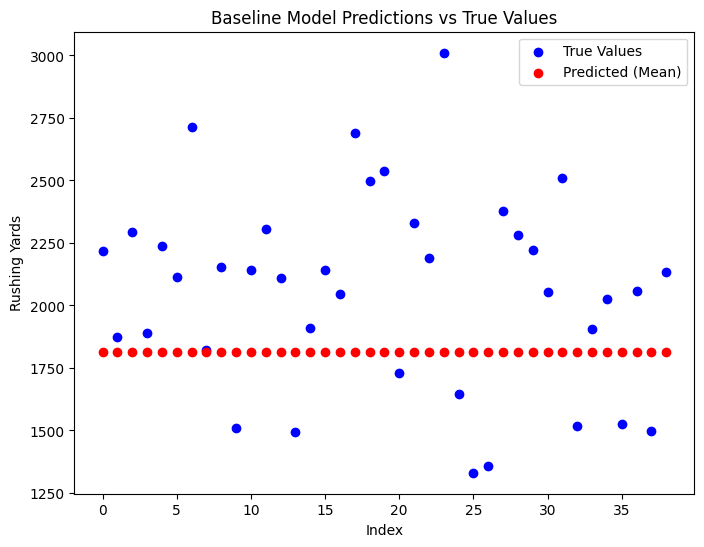

RMSE: 142.8374
R^2 Score: 0.8631


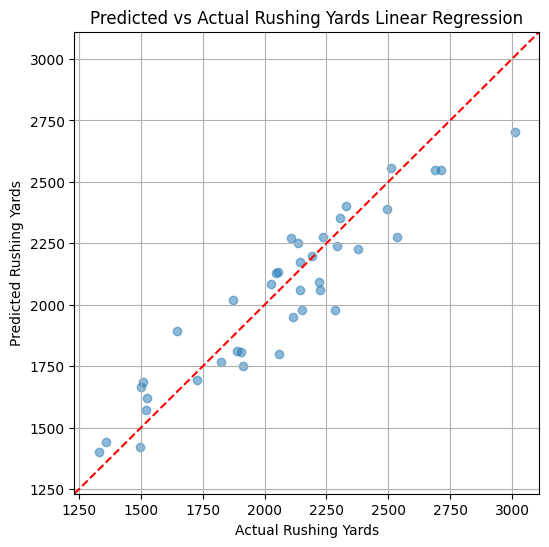

In [4]:
# @title
# Rushing Linear Regression
X = model1.drop(columns='Rushing Yards')
y = model1['Rushing Yards']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

#Baseline Model for Q1

mean_y_train = np.mean(y_train)

y_pred_baseline = np.full_like(y_test, mean_y_train)

r2_baseline = r2_score(y_test, y_pred_baseline)
rmse_baseline = np.sqrt(mean_squared_error(y_test, y_pred_baseline))

print(f"Baseline R² Score: {r2_baseline:.4f}")
print(f"Baseline RMSE: {rmse_baseline:.4f}")

plt.figure(figsize=(8, 6))
plt.scatter(range(len(y_test)), y_test, color='blue', label='True Values')
plt.scatter(range(len(y_pred_baseline)), y_pred_baseline, color='red', label='Predicted (Mean)')
plt.title('Baseline Model Predictions vs True Values')
plt.xlabel('Index')
plt.ylabel('Rushing Yards')
plt.legend()
plt.show()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Predicting on the test set
y_pred = model.predict(X_test_scaled)

# Evaluating performance
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.4f}")
print(f"R^2 Score: {r2:.4f}")

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
min_val = min(min(y_test), min(y_pred)) - 100
max_val = max(max(y_test), max(y_pred)) + 100
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')
plt.grid(True)
plt.ylabel('Predicted Rushing Yards')
plt.xlabel('Actual Rushing Yards')
plt.title('Predicted vs Actual Rushing Yards Linear Regression')
plt.show()

RMSE: 150.2886
R^2 Score: 0.8485


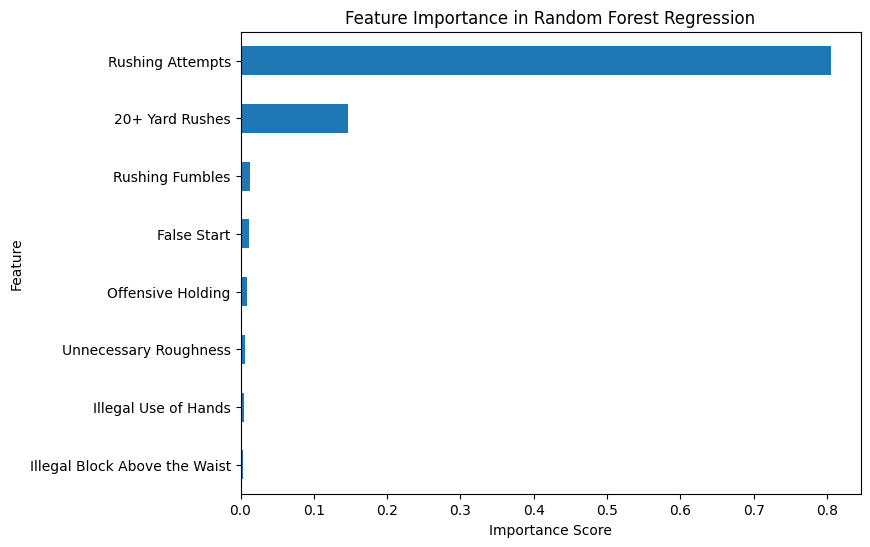

In [5]:
# Rushing Random Forest
X = model1.drop(columns='Rushing Yards')
y = model1['Rushing Yards']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# Predicting on the test set
y_pred = model.predict(X_test_scaled)

# Evaluating performance
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.4f}")
print(f"R^2 Score: {r2:.4f}")

feature_names = X.columns
importances = model.feature_importances_

# Plotting feature importance
pd.Series(importances, index=feature_names).sort_values().plot(kind='barh', figsize=(8, 6))
plt.title("Feature Importance in Random Forest Regression")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show();

In [6]:
# Alpha value fitting
alphas = [0.001, 0.01, 0.1, 1, 10, 100]

ridge = RidgeCV(alphas=alphas, cv=5)
lasso = LassoCV(alphas=alphas, cv=5)

ridge.fit(X_train_scaled, y_train)
lasso.fit(X_train_scaled, y_train)

print("Best Ridge alpha:", ridge.alpha_)
print("Best Lasso alpha:", lasso.alpha_)

Best Ridge alpha: 10.0
Best Lasso alpha: 10.0


RMSE: 143.2605
R^2 Score: 0.8623


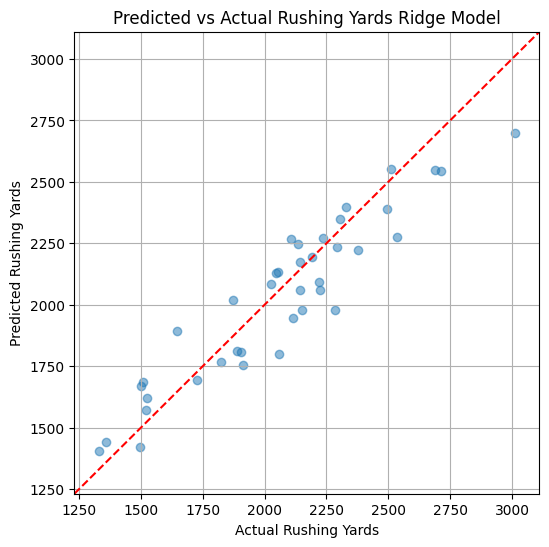

In [7]:
# Rushing Ridge
X = model1.drop(columns='Rushing Yards')
y = model1['Rushing Yards']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = Ridge(alpha=1)
model.fit(X_train_scaled, y_train)

# Predicting on the test set
y_pred = model.predict(X_test_scaled)

# Evaluating performance
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.4f}")
print(f"R^2 Score: {r2:.4f}")

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
min_val = min(min(y_test), min(y_pred)) - 100
max_val = max(max(y_test), max(y_pred)) + 100
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')
plt.grid(True)
plt.ylabel('Predicted Rushing Yards')
plt.xlabel('Actual Rushing Yards')
plt.title('Predicted vs Actual Rushing Yards Ridge Model')
plt.show()

RMSE: 146.5213
R^2 Score: 0.8560


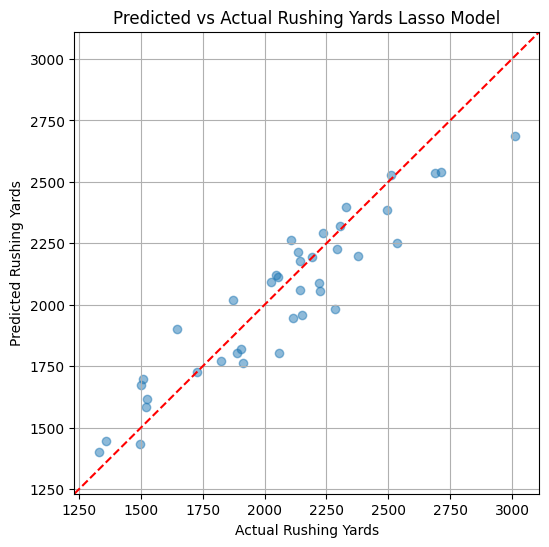

In [8]:
# Rushing Lasso
X = model1.drop(columns='Rushing Yards')
y = model1['Rushing Yards']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = Lasso(alpha=10)
model.fit(X_train_scaled, y_train)

# Predicting on the test set
y_pred = model.predict(X_test_scaled)

# Evaluating performance
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.4f}")
print(f"R^2 Score: {r2:.4f}")

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
min_val = min(min(y_test), min(y_pred)) - 100
max_val = max(max(y_test), max(y_pred)) + 100
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')
plt.grid(True)
plt.ylabel('Predicted Rushing Yards')
plt.xlabel('Actual Rushing Yards')
plt.title('Predicted vs Actual Rushing Yards Lasso Model')
plt.show()

In [9]:
# Rushing VIF
data = pd.DataFrame()
data['Feature'] = X.columns
data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(data)

                         Feature        VIF
0              Offensive Holding   8.335492
1                    False Start   6.827285
2          Unnecessary Roughness   2.669341
3  Illegal Block Above the Waist   1.796159
4           Illegal Use of Hands   2.512005
5               Rushing Attempts  17.535257
6                Rushing Fumbles   6.263693
7                20+ Yard Rushes   8.402676


Baseline R² Score: -0.1233
Baseline RMSE: 544.7437


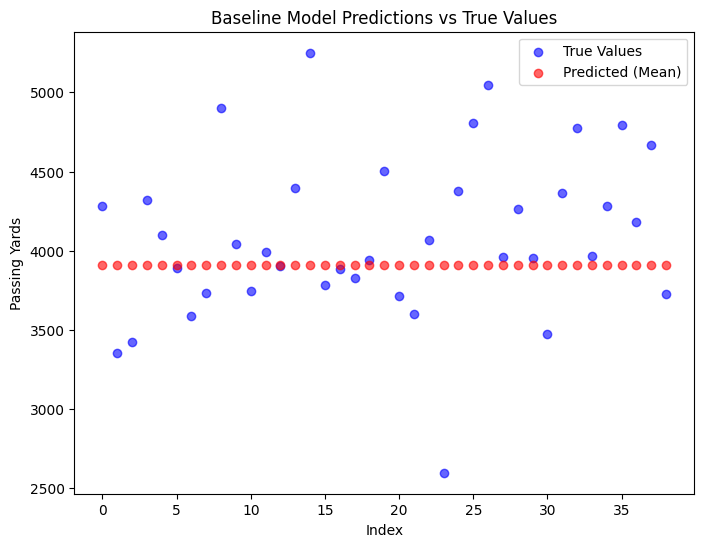

RMSE: 311.3639
R^2 Score: 0.6330


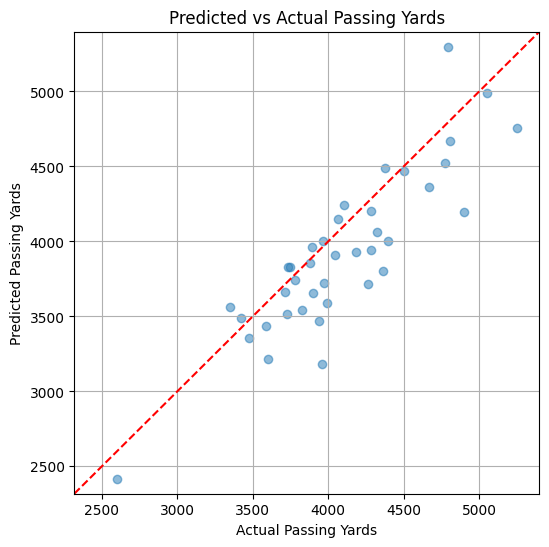

In [10]:
# Passing Linear Regression
X = model2.drop(columns='Passing Yards')
y = model2['Passing Yards']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

#Baseline Model for Q2

mean_y_train = np.mean(y_train)

y_pred_baseline = np.full_like(y_test, mean_y_train)

r2_baseline = r2_score(y_test, y_pred_baseline)
rmse_baseline = np.sqrt(mean_squared_error(y_test, y_pred_baseline))

# Print or return the metrics
print(f"Baseline R² Score: {r2_baseline:.4f}")
print(f"Baseline RMSE: {rmse_baseline:.4f}")

plt.figure(figsize=(8, 6))
plt.scatter(range(len(y_test)), y_test, color='blue', label='True Values', alpha=0.6)
plt.scatter(range(len(y_pred_baseline)), y_pred_baseline, color='red', label='Predicted (Mean)', alpha=0.6)
plt.title('Baseline Model Predictions vs True Values')
plt.xlabel('Index')
plt.ylabel('Passing Yards')
plt.legend()
plt.show()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Predicting on the test set
y_pred = model.predict(X_test_scaled)

# Evaluating performance
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.4f}")
print(f"R^2 Score: {r2:.4f}")

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
min_val = min(min(y_test), min(y_pred)) - 100
max_val = max(max(y_test), max(y_pred)) + 100
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')
plt.grid(True)
plt.ylabel('Predicted Passing Yards')
plt.xlabel('Actual Passing Yards')
plt.title('Predicted vs Actual Passing Yards')
plt.show()

RMSE: 335.8014
R^2 Score: 0.5731


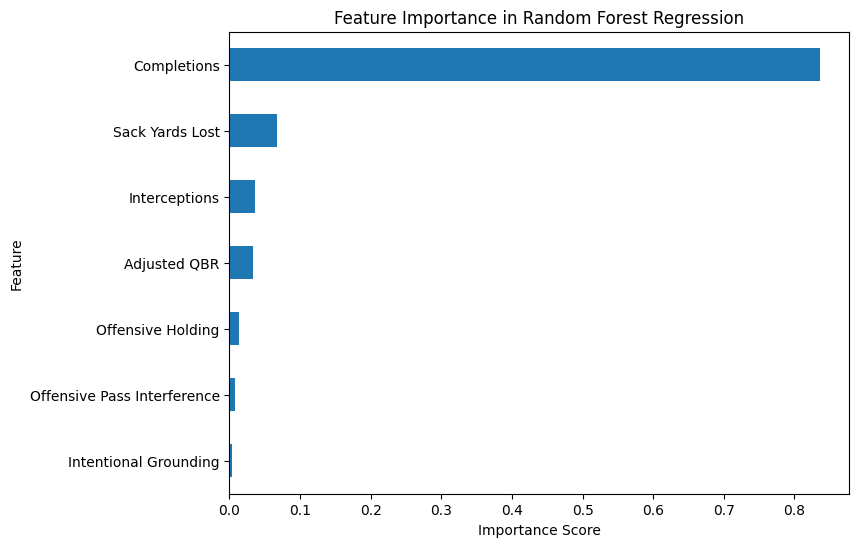

In [11]:
# Passing Random Forest
X = model2.drop(columns='Passing Yards')
y = model2['Passing Yards']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# Predicting on the test set
y_pred = model.predict(X_test_scaled)

# Evaluating performance
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.4f}")
print(f"R^2 Score: {r2:.4f}")


feature_names = X.columns
importances = model.feature_importances_

# Plotting feature importance
pd.Series(importances, index=feature_names).sort_values().plot(kind='barh', figsize=(8, 6))
plt.title("Feature Importance in Random Forest Regression")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show();


In [12]:
# Alpha value fitting
alphas = [0.001, 0.01, 0.1, 1, 10, 100]

ridge = RidgeCV(alphas=alphas, cv=5)
lasso = LassoCV(alphas=alphas, cv=5)

ridge.fit(X_train_scaled, y_train)
lasso.fit(X_train_scaled, y_train)

print("Best Ridge alpha:", ridge.alpha_)
print("Best Lasso alpha:", lasso.alpha_)

Best Ridge alpha: 1.0
Best Lasso alpha: 10.0


RMSE: 310.6557
R^2 Score: 0.6347


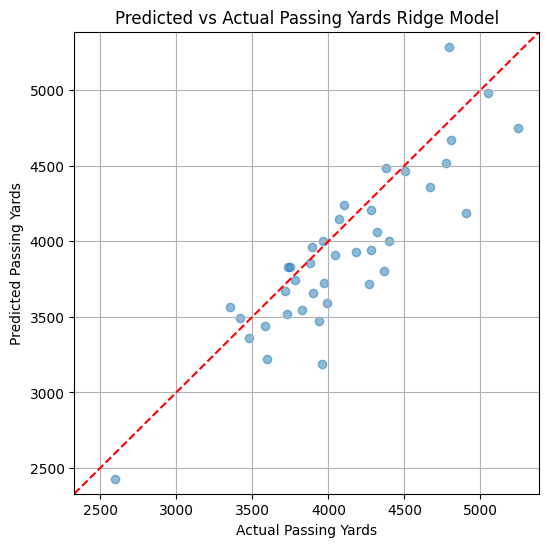

In [13]:
# Rushing Ridge
X = model2.drop(columns='Passing Yards')
y = model2['Passing Yards']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = Ridge(alpha=1)
model.fit(X_train_scaled, y_train)

# Predicting on the test set
y_pred = model.predict(X_test_scaled)

# Evaluating performance
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.4f}")
print(f"R^2 Score: {r2:.4f}")

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
min_val = min(min(y_test), min(y_pred)) - 100
max_val = max(max(y_test), max(y_pred)) + 100
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')
plt.grid(True)
plt.ylabel('Predicted Passing Yards')
plt.xlabel('Actual Passing Yards')
plt.title('Predicted vs Actual Passing Yards Ridge Model')
plt.show()

RMSE: 306.4167
R^2 Score: 0.6446


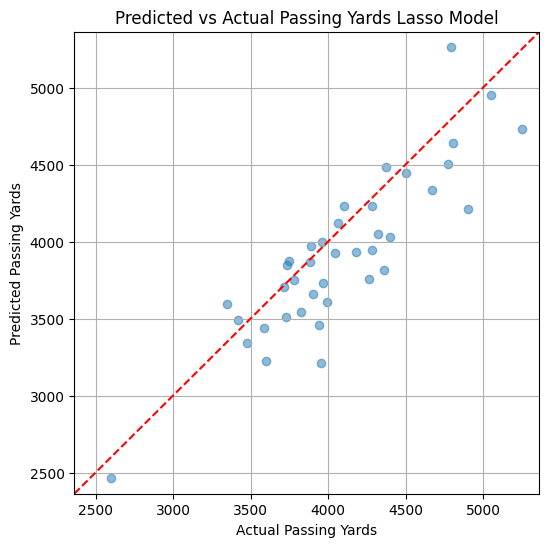

In [14]:
# Passing Lasso
X = model2.drop(columns='Passing Yards')
y = model2['Passing Yards']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = Lasso(alpha=10)
model.fit(X_train_scaled, y_train)

# Predicting on the test set
y_pred = model.predict(X_test_scaled)

# Evaluating performance
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.4f}")
print(f"R^2 Score: {r2:.4f}")

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
min_val = min(min(y_test), min(y_pred)) - 100
max_val = max(max(y_test), max(y_pred)) + 100
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')
plt.grid(True)
plt.ylabel('Predicted Passing Yards')
plt.xlabel('Actual Passing Yards')
plt.title('Predicted vs Actual Passing Yards Lasso Model')
plt.show()

In [15]:
# Passing VIF
data = pd.DataFrame()
data['Feature'] = X.columns
data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(data)

                       Feature        VIF
0                Interceptions  10.259678
1              Sack Yards Lost  11.302214
2                 Adjusted QBR   5.149369
3                  Completions  19.697109
4        Intentional Grounding   1.198732
5            Offensive Holding   4.797417
6  Offensive Pass Interference   1.770708
